# CITS4403 - Perth Train Network from Slime Mould

22234771 - Benjamin Longbottom

## Imports
NOTE: imports must be installed from pipenv (see `README.md`)

In [12]:
import math
import numpy as np
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import rasterio

### Enable matplotlib interactive plots
This is needed for the animation of the model.

In [13]:
%matplotlib notebook

## Utility Functions

In [14]:
def bounded_range(minimum, lower_request, upper_request, maximum):
    """ returns a range between lower and upper request, with hard boundaries at minimum and maximum. """
    
    return range(max(minimum, lower_request), min(maximum, upper_request))
    

## Grid Class
This class provides the base functionality for grids defined later. 

In [4]:
class Grid:
    """
    A 2 dimensional grid, with a single value assigned to each cell.
    
    The grid is stored as a 2 dimensional numpy array in `self.grid`, 
    using the cartesian plane with [x,y] indexing. The origin is in
    the lower left.
    """
    
    def __init__(self, shape=(200, 100), dtype=np.float32):
        self.shape = shape
        self.width, self.height = shape
        self._im = None
        self.dtype = dtype
        self.grid = None
        self.setup_grid()
    
    def setup_grid(self):
        """ 
        Defined separately to the `__init__` method to act as a hook. 
        
        i.e. child classes may override this method instead of `__init__`,
        allowing grid instances to maintain consistent base attributes.
        """
        self.clear_grid()
        
    def clear_grid(self):
        """ 
        Replaces `self.grid` with a new 2D array, full of 0s.
        """
        self.grid = np.zeros((self.shape), dtype=self.dtype)
    
    def randomise_grid(self):
        """
        Replaces `self.grid` with a new 2D array of random values.
        """
        self.grid = np.random.rand(self.width, self.height)
        
    def add_spot(self, centre_coords, value, radius=0):
        """
        Add a 'spot', or a square at a location with all cells set to `value`.
        
        The spot is a square with height and width of `(2 * radius) + 1`.
        """
        x_centre, y_centre = centre_coords
        
        for xi in bounded_range(0, x_centre-radius, x_centre+radius+1, self.width):
            for yi in bounded_range(0, y_centre-radius, y_centre+radius+1, self.height):
                self.grid[xi, yi] = value
        
    def get_neighbour_indicies(self, cell_coords, neighbourhood=4):
        """
        An iterator which provides all neighbour coordinates for cell_coords.
        
        Checks ensure that only valid neighbours are returned.
        """
        cell_x, cell_y = cell_coords
        
        for x_dir in [-1, 0, 1]:
            for y_dir in [-1, 0, 1]:
                neighbour_x = cell_x + x_dir
                neighbour_y = cell_y + y_dir

                if neighbourhood not in [4, 8]:
                    raise ValueError("Neighbourhood can only be 4 or 8.")
                # if a 4-neighbourhood, skip any corner neighbours.
                elif neighbourhood == 4 and abs(x_dir) == 1 and abs(y_dir) == 1:
                    continue
                
                # skip any neighbours that fall outside of grid boundaries.
                if 0 > neighbour_x or neighbour_x >= self.width:
                    continue
                if 0 > neighbour_y or neighbour_y >= self.height:
                    continue

                yield (neighbour_x, neighbour_y)
    
    # --- Visualisation
    
    def draw(self, animated=False):
        """
        Draws the current CA state on a 2D cartesian plane.
        
        Origin is lower-left. This matches grid indexing of [x,y].
        """
        transposed_grid = self.grid.T
        if self._im is None:
            self._im = plt.imshow(transposed_grid, origin='lower', animated=animated)
        else:
            self._im.set_array(transposed_grid)
            
        return self._im
        

### Terrain Grids
Terrain grids are used to represent terrain. Specifically, these grids provide a value to indicate the difficulty to traverse the grid.

In [5]:
class Terrain_Grid(Grid):
    """
    A grid specifically for generating random terrain. 
    """
    dtype = np.int32
    
    def setup_grid(self):
        self.randomise_grid()
        self.out_of_bounds = np.zeros(self.shape, dtype=self.dtype)
        self.grid = self.grid * 5 + 1

#### Terrain from raster files
It is common for geographic information to be stored in a 'raster' format - which is effectively an image with each 'pixel' containing the value prescribed to the location that the pixel covers.

`Terrain_Raster_Grid` contains functionality to read, pre-process and store terrain data from a raster file.

The module `rasterio` is used to import the terrain. By default, it gives any undefined cell a value of -9999. In the case of the terrain data, only the ocean is undefined. Therefore, all cell locations with -9999 are saved as 'out of bounds' and used later. The 'out of bounds' cells are set to 0 purely to make a drawn image more readable (as it reduces the variance in cell values).

The implementation of `Circle_Growth_Grid` (later in this notebook) requires that the value in any terrain cell must be greater than 0 (assuming it is not 'out of bounds'). Normalisation of the imported raster file is used to ensure that all values (other than those out of bounds) are above 0. The weighting of the terrain's impact is also manipulated through normalisation. Therefore, the `normalise_grid` method takes a range to normalise the terrain values into. Normalisation is first done between 0 and 1 with the following equation:

\begin{equation} 
terrain\_normalised = \frac{terrain - min(terrain)}{max(terrain) - min(terrain)} \end{equation}

Then the values between 0 and 1 are mapped to the `normalised_range` with the equation:

\begin{equation} 
terrain\_normalised\_to\_range = terrain\_normalised * (range[max] - range[min]) + range[min] \end{equation}

In [6]:
class Terrain_Raster_Grid(Grid):
    """
    A grid containing terrain imported from a raster file.
    """

    dtype = np.int32
    
    def __init__(self, filename, normalised_range=(1,2)):
        # Attributes
        self._im = None
        self.grid = None
        self.shape = None
        self.width = None
        self.height = None
        self.out_of_bounds = None
        # Checks & Assignement
        with rasterio.open(filename) as src:
            raster = src.read()
        self.grid = raster[0]  
            # ^ geotif raster is monochromatic, so get the only value for each pixel.
        self.shape = self.grid.shape
        self.width, self.height = self.grid.shape    
        self.out_of_bounds = self.grid == -9999
            # ^ rasterio sets undefined cells to -9999. terrain datasets do not define 
            #   data for the ocean. Therefore, this out_of_bounds provides a lookup for
            #   whether a cell is in the ocean or not.
        self.normalise_grid(normalised_range)
        
    def normalise_grid(self, normalised_range):
        """
        Normalise grid values to a normalised range. Any cells that are 
        'out_of_bounds' are set to 0, primarily for better visualisation.
        
        - If `normalised_range=(1,1)`, then all values will be set to 1.
        """
        normalised_min, normalised_max = normalised_range
        self.grid[self.out_of_bounds] = 0
        min_value = np.min(self.grid[self.out_of_bounds == False])
        max_value = np.max(self.grid)
        zero_to_one_normalised = ((self.grid[self.out_of_bounds == False] - min_value) / (max_value - min_value))
        self.grid[self.out_of_bounds == False] = np.array(zero_to_one_normalised * (normalised_max - normalised_min) + normalised_min, dtype=self.dtype)

### Growth Grid
This section contains an implementation of a Cellular Automata (CA) that models 'growth' from a starting spot on a grid. As the CA 'grows', it expands in a circular-like pattern and stores the distance travelled to reach each visited cell. Distance in this implementation includes the cost of travelling over terrain. Growth can re-explore already visited cells if a shorter path is found and eventually guarantee each cell has the shortest distance possible.

####  Concept for the Growth-Step Process
The process of growth is theoretically a CA with local state and local rule-based interactions only. The process for each step can be decribed with the rules below:
- Neighbour Rule: cell only updates if they are next to a cell with 'growth' in it.
- Circle-Growth Rule: cell updates if they not yet visited and within the circular growth pattern.
    - based on starting cell coordinates, current cell position coordinates and growth radius.
        - starting cell coordinates propagated to all cells in 'growth'.
        - current cell coordinates incremented from previous cell's coordinates.
        - growth radius incremented from neighbouring cell with lowest growth_radius (starting cell has growth_radius of 0).
- Distance Rule: all visited cells update distance based on lowest distance neighbour
    - cell distance is distance of visited neighbouring cell with lowest distance + terrain value of current cell.

For these rules to work, the terrain values for each cell must be greater than 0 to ensure that distance always increases during growth. This is important for path-finding (implemented later in the notebook). 

Once no more neighbours can be updated, the grid contains the accumulated distance to each cell from the start. This is effectively the greedy search component of Dijkstra's shortest path algorithm in a CA. 


##### Growing in a circle
The implementation of this CA uses the method `circle_neighbours()` to filter neighbours of a cell so that the growth to neighbours achieves a global circle pattern. The exact pattern is determined by `circle_type`, which is set at instantiation.

If `circle_type = "approx"` then all neighbours in a 'von-neumann' neighbourhood (4-neighbourhood) are given.

When `circle_type = "true"`, neighbours in a "moore" neighbourhood (8-neighbourhood) are filtered based on the euclidean distance from the starting spot. The filter only returns neighbours with euclidean distances less than the current number of steps, thus resulting in a circle with radius equal to the number of steps.

The euclidean distance from the starting spot ($centre$) to a $neighbour$ is calculated with the formula below:

\begin{equation} distance = \sqrt{(centre[x] - neighbour[x])^2 + (centre[y] - neighbour[y])^2} \end{equation}


#### Implementation of the Growth-Step Process
The implementation is not a pure CA, as some changes have been made to make the `step()` method more space and time efficient. For example, the starting cell coordinates are not stored by all cells and is stored globally in the `centre_coords` attribute, since it stays the same for each cell in the grid. 

The implementation also memoises the cells that were updated in the previous step - or the edge of growth - in the `_edge_indicies` attribute. The neighbours of these are then explored, instead of all cells and their neighbours being explored. this reduces computation needed to find cells that meet the CA rules of growth, especially considering the relatively small amount of updatable cells in each step.


In [7]:
class Circle_Growth_Grid(Grid):
    """
    A 2D Cellular Automata which 'grows' outwards from a centre point in a 
    circle-like pattern. The growth keeps track of the distance from the starting
    spot. This class also considers terrain when calculating distance.
    
    `circle_type = "true"`  : calculates all cells that make a circle based on the 
                              cell coordinate, starting spot coordinate and number of steps.

    `cirle_type = "approx"` : uses a 4-neighbourhood as an approximation of a circle. This 
                              is faster to compute, but makes distance calculations skewed
                              in favour of straight North, West, East, or South.
    """
    # class attributes
    dtype = np.int32
    background_value = 0
    neighbour_number_map = {
        'true' : 8,
        'approx': 4
    }
    
    def __init__(self, shape=(200, 100), circle_type='true', terrain_grid=None):
        """
        Override `Grid.__init__` to include circle_type and terrain_grid parameters.
        """
        # Attributes
        self.centre_coords = (None, None)
        self.circle_type = circle_type
        self.terrain_grid = None
        self.shape = shape
        # Checks & assignment
        if circle_type not in ['true', 'approx']:
            raise ValueError('circle_type must be "true" or "approx".')
        self.neighbour_number = self.neighbour_number_map[circle_type]
        # give a random terrain if no terrain_grid provided.
        if self.terrain_grid is None:
            terrain_grid = Terrain_Grid(self.shape)
        self.terrain_grid = terrain_grid
        super().__init__(shape=shape, dtype=self.dtype)
        self._init_step_attrs()  
            # ^ moves step-based init attributes above the step function
            #   for easier reading.
        
    def setup_grid(self):
        """
        Overrides setup_grid in the case that background_value is not 0.
        """
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
    
    def add_spot(self, centre_coords):
        """
        Adds a spot at centre_coords. A spot in this grid represents the starting position
        of the growth.
        """
        centre_coords_already_set = None not in self.centre_coords
        if centre_coords_already_set:
            raise Exception(f"Cannot add more than 1 spot to an instance of: {self.__class__.__name__}")
            
        self.centre_coords = centre_coords
        super().add_spot(centre_coords, 1, radius=0)
        
    def circle_neighbours(self, cell):
        """
        Iterator returning all neighbours of cell that fall within the circular growth,
        as dictated by 'circle_type'.
        """
        centre_x, centre_y = self.centre_coords

        for neighbour_x, neighbour_y in self.get_neighbour_indicies(cell, neighbourhood=self.neighbour_number):
            if self.circle_type == 'true':
                # skip any neighbours outside of 'circle' with radius step_count
                neighbour_dist_from_centre = math.sqrt((centre_x - neighbour_x) ** 2 + (centre_y - neighbour_y) ** 2)
                if neighbour_dist_from_centre > self.step_count + 1:
                    continue
            yield neighbour_x, neighbour_y
    
    def _init_step_attrs(self):
        """
        Brings `__init__` code closer to the`step` method for readability.
        """
        self.step_count = 0
        self._edge_indicies = None
            # ^ stores the cells that currently are the 'edge' of growth.
    
    def step(self):
        """
        Grows outward in a circular-like pattern by one step. It also grows inward if 
        a shorter path to it is found to inner cells, ensuring that shorter paths due
        to navigating around terrain are considered.
        
        This implementation uses memoisation to remember the edge of the growth.
        """
        # used for memoising edges.
        next_edges_x = []
        next_edges_y = []
        # check for starting condition
        if self._edge_indicies is None:
            self._edge_indicies = np.where(self.grid > self.background_value)
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            cell_value = self.grid[cell] 
            for neighbour_x, neighbour_y in self.circle_neighbours(cell):
                neighbour = (neighbour_x, neighbour_y)
                neighbour_value = self.grid[neighbour]
                neighbour_terrain = self.terrain_grid.grid[neighbour]
                # ignore any 'out_of_bounds' neighbours - they are in the sea!
                if self.terrain_grid.out_of_bounds[neighbour]:
                    continue
                # update neighbours with either no or worse distances.
                if neighbour_value == self.background_value or neighbour_value > cell_value + neighbour_terrain:
                    next_edges_x.append(neighbour_x)
                    next_edges_y.append(neighbour_y)
                    self.grid[neighbour] = cell_value + neighbour_terrain
        # memoise edge for next step.
        self._edge_indicies = (next_edges_x, next_edges_y)
        self.step_count += 1
        return self.grid

### Paths and Path-Finding
This section outlines a class that finds the shortest path though a grid of accumulated distances, as provided by the `Circle_Growth_Grid` class.

The `Slime_Path` class provides functionality for finding and storing shortest paths. 

TODO
- uses distance_grid for distances (output of dijkstra's search algorithm).
- implements path-finding of dijkstra's.



In [8]:
class Slime_Path:
    """
    Class for finding and storing paths.
    """
    
    def __init__(self, neighbour_number):
        self._setup_data_structure()
        self._setup_metrics()
        if neighbour_number not in [4, 8]:
            raise ValueError()
        self.neighbour_number = neighbour_number
        
    def _setup_data_structure(self):
        self.x_coords = []
        self.y_coords = []
        self.stack = []
        self.neighbour_seen_sets = dict()
        self.iterations = 0
                
    def _setup_metrics(self):
        self.distance = None
        
    def distance_is_less_than(self, value):
        """
        Boolean indicating whether the current path distance
        is less than `value`. If distance is not yet set, this
        returns False.
        """
        return self.distance is not None and self.distance < value
        
    def find_shortest_path_from(self, distance_grid, start_spot):
        """
        Find the shortest path from `spot` to the other spot that
        created `distance_grid`. This method sets up `self` for 
        the `_recursive_shortest_path_from` method, and handles
        any failed calls to that method.
        """
        new_distance = distance_grid.grid[start_spot]
        # only recalculate path if a lower distance path exists.
        if not self.distance_is_less_than(new_distance):
            self.distance = new_distance
            self._setup_data_structure()
            self.stack.append(start_spot)
            cell_distance = distance_grid.grid[start_spot]
            while self.stack and cell_distance != 1:
                cell = self.stack.pop()
                cell_x, cell_y = cell
                self.x_coords.append(cell_x)
                self.y_coords.append(cell_y)
                if cell not in self.neighbour_seen_sets.keys():
                    self.neighbour_seen_sets[cell] = set()
                cell_distance = distance_grid.grid[cell]
                neighbour_found = False
                sorted_neighbours = []
                for neighbour_x, neighbour_y in distance_grid.get_neighbour_indicies(cell, self.neighbour_number):
                    neighbour = (neighbour_x, neighbour_y)
                    neighbour_distance = distance_grid.grid[neighbour]
                    if neighbour_distance == distance_grid.background_value:
                        continue
                    if neighbour_distance < cell_distance and neighbour not in self.neighbour_seen_sets[cell]:
                        neighbour_found = True
                        sorted_neighbours.append( (neighbour_distance, *neighbour) )
                sorted_neighbours.sort(key=lambda x: x[0])  # sort by distance
                if neighbour_found:
                    for neighbour_distance, neighbour_x, neighbour_y in sorted_neighbours:
                        # skip all cells not yet covered by growth.
                        neighbour = neighbour_x, neighbour_y
                        self.stack.append(neighbour)
                        self.neighbour_seen_sets[cell].add(neighbour)
                elif not neighbour_found and cell_distance != 1:
                    self.x_coords.pop()
                    self.y_coords.pop()
                self.iterations += 1
        

# Slime Mould Cellular Automata Model
This model of slime uses a combination of `Circle_Growth_Grid` instances and `Slime_Path` instances together to implement a slime-mould inspired cellular automata model, which provides the shortest path between all spots in the grid.



In [9]:
class Slime_Grid(Grid):
    """ A grid of the Slime_CA. """
    
    def __init__(
        self,
        shape=None,
        terrain_filename=None,
        dtype=np.int32,
        circle_type='true',
        visualise_type='distance',
        terrain_normalised_range=(1,100)
    ):
        # Attributes
        self.terrain_filename = terrain_filename
        self.circle_type = circle_type
        self.visualisers = {
            'edge'     : self._visualise_next_steps_edge,
            'path'     : self._visualise_found_paths,
            'distance' : self._visualise_distance_from_spots,
            'start'    : self._visualise_paths_from_start,
        }
        self.visualise_type = None

        # Checks & assignment
        if visualise_type not in self.visualisers.keys():
            raise ValueError ('Invalid visualiser type.')
        self.visualise_type = visualise_type
        if shape is None and terrain_filename is None:
            raise ValueError('Need either shape or terrain_filename to be set')
        if shape is not None:
            super().__init__(shape, dtype)
            self.generate_terrain()
        else:
            self.setup_terrain(terrain_filename, terrain_normalised_range)
            super().__init__(self.shape, dtype)
        # Convenience
        self._init_step_attrs()
        self._init_draw_attrs()
    
    def setup_grid(self, terrain_normalised_range=None):
        """
        Sets up the multiple grids used for this CA. Each spot
        is given its own distance_grid when added.
        """
        self.distance_grids = dict()  # will contain distance_grids for each spot..
        self.visualisation_grid = Grid(self.shape, dtype=np.int32)
        
    def setup_terrain(
        self,
        terrain_filename,
        terrain_normalised_range=None
    ):
        """
        Import terrain from `terrain_filename` and set up
        CA shape based on terrain size.
        """
        self.terrain_grid = Terrain_Raster_Grid(self.terrain_filename,
                                                normalised_range=terrain_normalised_range)
        self.shape = self.terrain_grid.shape
    
    def generate_terrain(self):
        self.terrain_grid = Terrain_Grid(self.shape)
        
    def add_spot(self, centre_coords):
        """
        Add a new spot at centre_coords by creating a distance_grid for it,
        setting it up with the spot and storing it in the `distance_grids` dict.
        """
        new_dist_grid = Circle_Growth_Grid(shape=self.shape,
                                                    circle_type=self.circle_type,
                                                    terrain_grid=self.terrain_grid)
        new_dist_grid.add_spot(centre_coords)
        self.distance_grids[centre_coords] = new_dist_grid
        
    def set_start(self, starting_coords):
        """
        Choose the starting spot that will begin growing.
        """
        self.starting_spot = starting_coords
        
    def does_index_have_spot(self, coords):
        """
        Returns True if coords is a spot.
        """
        return coords in self.distance_grids.keys()
    
    def _circle_growth_syncer(self, spots_to_step, keep_synced=False):
        """
        if keep_synced is True, this method forces only the lowest stepped spots
        to grow until all spots are at the same step.
        """
        if keep_synced:
            # if any found spot has less steps than the others, only step that spot until it matches the others.
            prev_spot_step_count = None
            for spot in self.found_spots:
                spot_distance_grid = self.distance_grids[spot]
                spot_step_count = spot_distance_grid.step_count
                # TODO: change to set spots_to_step to the spot with lowest step_count
                if prev_spot_step_count is not None and prev_spot_step_count != spot_step_count:
                    spots_to_step = [spot]
                prev_spot_step_count = spot_step_count
        return spots_to_step
          
    def _init_step_attrs(self):
        self.step_count = 0
        self.found_spots = set()
        self.found_paths = set()
        self.paths = dict()  # (end_spot, start_spot) : Slime_Path
    
    def step(self):
        """
        Do one step of the growth and path-finding phase. This grows all found spots by one step
        and does path-finding for any found spots.
        """
        spots_to_step = self._circle_growth_syncer(self.found_spots, keep_synced=False)
        spots_to_step = spots_to_step.copy()  # copy allows adding to found_spots during for loop
        spots_to_step.add(self.starting_spot)
        # growth phase
        for spot in spots_to_step:
            distance_grid = self.distance_grids[spot]
            distance_grid.step()
            for cell in zip(*distance_grid._edge_indicies):
                path_ends = cell, spot
                if self.does_index_have_spot(cell) and path_ends not in self.found_paths:
                    self.found_spots.add(cell)
                    self.found_paths.add(path_ends)
                    self.paths[path_ends] = Slime_Path(neighbour_number=distance_grid.neighbour_number)
        # path-finding phase
        #     this requires at least 1 spot to be found through growth.
        for path_ends in self.found_paths:
            spot_path = self.paths[path_ends]
            end_cell, start_cell = path_ends
            start_distance_grid = self.distance_grids[start_cell]
            if start_distance_grid.grid[end_cell] != 0:
                spot_path.find_shortest_path_from(start_distance_grid, end_cell)
        # prepare visualisation_grid for interpreting all grids based on
        # visualisation type.
        self.visualisers[self.visualise_type]()  
        self.step_count += 1
        return self.visualisation_grid.grid

    def _visualise_next_steps_edge(self):
        """
        See all the cells to be processed for the growth phase
        in the next step. (Aggregation of all distance_grids)
        """
        self.visualisation_grid.clear_grid()
        for distance_grid in self.distance_grids.values():
            # if _edge_indicies is empty, then visualisation fails.
            if distance_grid._edge_indicies:
                self.visualisation_grid.grid[distance_grid._edge_indicies] = self.max_distance
            
    def _visualise_distance_from_spots(self):
        """
        See the distance from all spots as it grows.
        """
        for distance_grid in self.distance_grids.values():
            if distance_grid._edge_indicies:
                self.visualisation_grid.grid[distance_grid._edge_indicies] = distance_grid.grid[distance_grid._edge_indicies]

    def _visualise_found_paths(self):
        """
        See all found paths.
        """
        self.visualisation_grid.clear_grid()
        for path_ends in self.found_paths:
            spot_path = self.paths[path_ends]
            self.visualisation_grid.grid[spot_path.x_coords, spot_path.y_coords] = self.max_distance
    
    def _visualise_paths_from_start(self):
        self.visualisation_grid.clear_grid()
        spot_paths = [ x for x in self.found_paths if x[1] == self.starting_spot]
        for path_ends in spot_paths:
            spot_path = self.paths[path_ends]
            self.visualisation_grid.grid[spot_path.x_coords, spot_path.y_coords] = self.max_distance
        distance_grid = self.distance_grids[self.starting_spot]    
        self.visualisation_grid.grid[distance_grid._edge_indicies] = self.max_distance

    
    def _init_draw_attrs(self):
        self.max_distance = math.sqrt(math.pow(self.height, 2) + math.pow(self.width, 2))
    
    def draw(self, animated=False):
        return self.visualisation_grid.draw(animated=animated)
        


## Cellular Automata Animator
This section implements a wrapper for animating Cellular Automatas.

In [10]:
class CA_Animator:
    """
    Animator for Cellular automatas.
    """
    
    def __init__(self, ca, fig=None):
        self.ca = ca
        if fig is None:
            fig = plt.figure()
        self.fig = fig
        self.current_frame = 0
        self.cbar = None
     
    def animate(self, frame_count=10, interval=20):
        """
        Begins animation.
        """
        self.frame_count = frame_count
        self.anim = ani.FuncAnimation(
            self.fig, 
            self._update_frame, 
            init_func=self._setup_fig, 
            frames=self.frame_count, 
            interval=interval,
            repeat=False)
        plt.show()
        return self.anim
    
    def _setup_fig(self, *args):
        """
        Callback function for setting up animation.
        """
        self.im = self.ca.draw(animated=True)
        # put a colourbar next to image and scale it to max distance.
        self.cbar = plt.colorbar(self.im)
        max_distance = math.sqrt(math.pow(self.ca.height, 2) + math.pow(self.ca.width, 2))
        plt.clim(0, max_distance)
        return (self.im,)
    
    def _update_frame(self, frame_index):
        new_grid = self.ca.step()
        self.im = self.ca.draw()
        if frame_index <= self.frame_count:
            self.current_frame = frame_index
            return (self.im,)


## Running the Slime Mould CA model

<IPython.core.display.Javascript object>


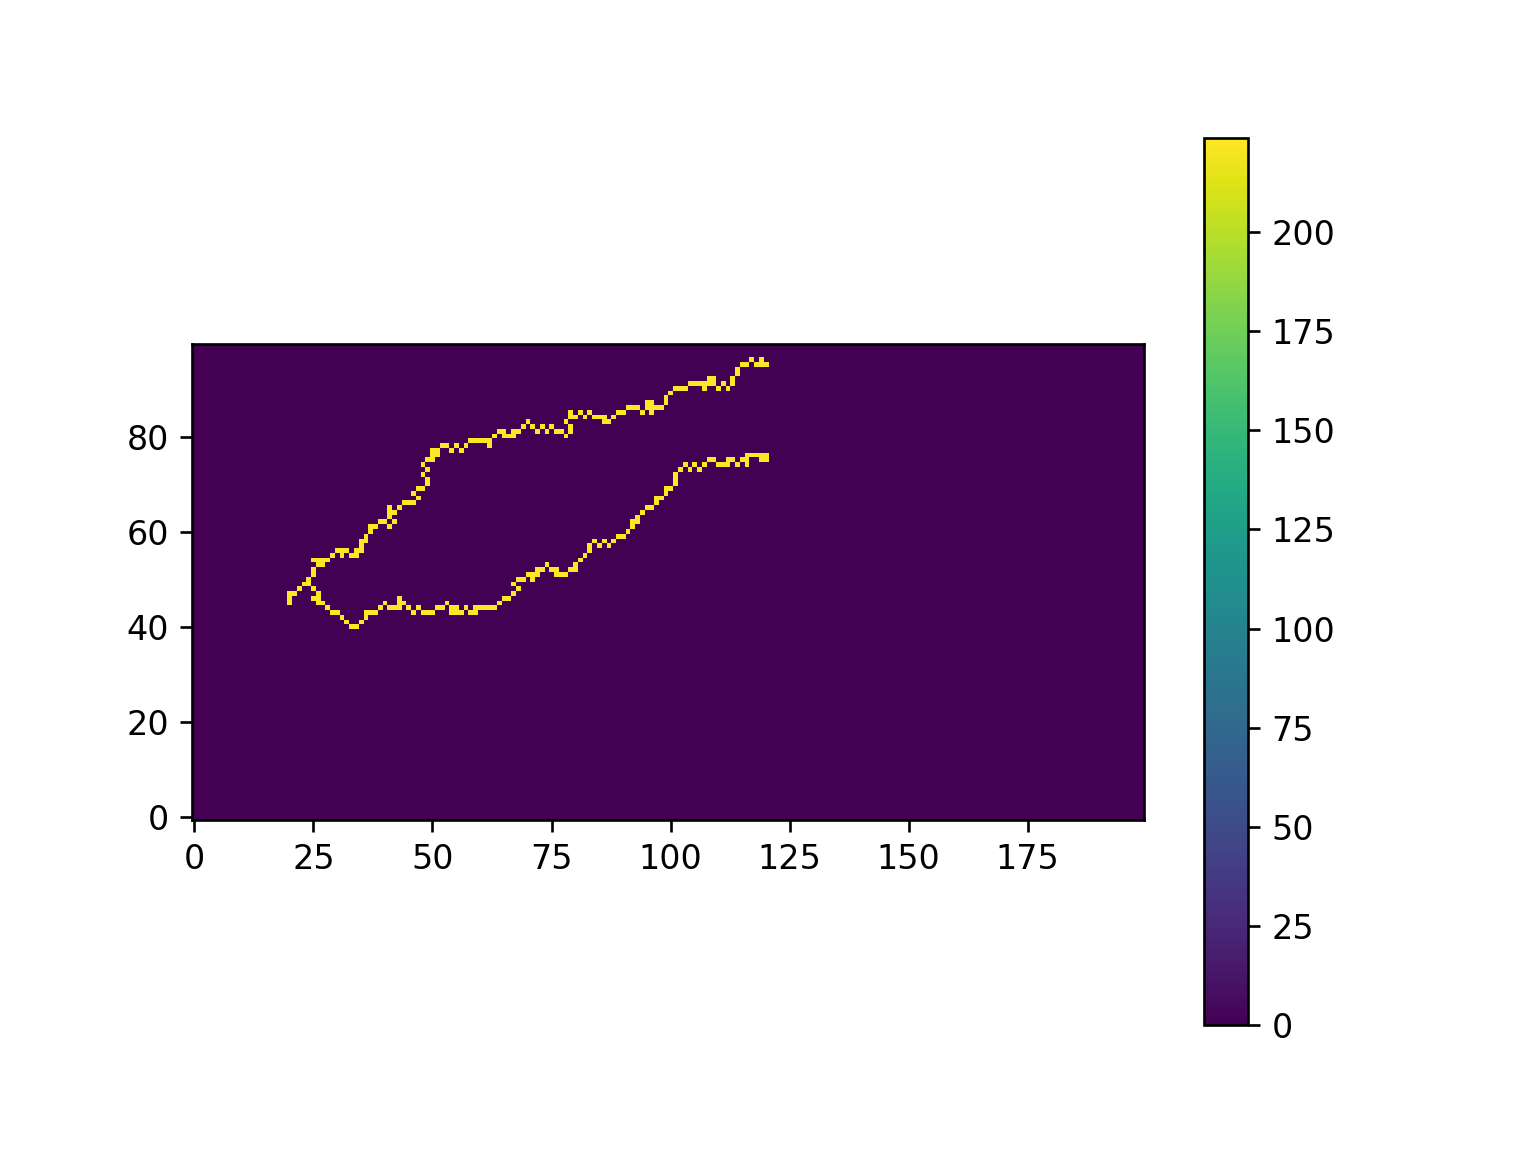

In [11]:
ca = Slime_Grid(shape=(200,100), circle_type='true', visualise_type='start')
starting_coords = (20, 45)
ca.add_spot(starting_coords)
ca.set_start(starting_coords)
ca.add_spot((120, 75))
ca.add_spot((120, 95))

animator = CA_Animator(ca)
animator.animate(frame_count=400, interval=0)

In [ ]:
ca = Slime_Grid(shape=(200,100), circle_type='approx', visualise_type='start')
starting_coords = (20, 45)
ca.add_spot(starting_coords)
ca.set_start(starting_coords)
ca.add_spot((120, 75))
ca.add_spot((120, 95))

for _ in range(401):
    ca.step()

# Railstops

In [ ]:
with rasterio.open('railstops--raster.tif') as src:
    railstops = src.read()[0]

In [ ]:
railstops_x, railstops_y = np.where(railstops == 1)
len(railstops_x)

In [ ]:
railstop_grid = Grid(railstops.shape)
railstop_grid.grid = railstops
railstop_grid.draw()

In [ ]:
start_railstop = (126, 62)
chosen_railstops = [ (276, 27), (111, 94), (102, 116), (126, 116), (174, 118), (165, 17), (22, 15), (355, 18) ]
chosen_railstops.append(start_railstop)

In [ ]:
ca = Slime_Grid(terrain_filename='ruggedness--raster.tif',
                circle_type='true',
                visualise_type='start',
                terrain_normalised_range=(1, 100))
for spot in chosen_railstops:
    ca.add_spot(spot)
ca.set_start(start_railstop)


animator = CA_Animator(ca)
animator.animate(frame_count=500, interval=0)

In [ ]:
ca._visualise_paths_for((165,17))
ca.draw()

In [ ]:
ca.terrain_grid.draw()

In [ ]:
ca = Slime_Grid(terrain_filename='ruggedness--raster.tif',
                circle_type='true',
                visualise_type='path',
                terrain_normalised_range=(1, 100)
               )
for spot in zip(railstops_x, railstops_y):
    ca.add_spot(spot)
start_railstop = (railstops_x[0], railstops_y[0])
ca.set_start(start_railstop)


animator = CA_Animator(ca)
animator.animate(frame_count=1000, interval=0)

In [ ]:
ca = Slime_Grid(terrain_filename='ruggedness--raster.tif',
                circle_type='approx',
                visualise_type='path',
                terrain_normalised_range=(1, 1)
               )
for spot in chosen_railstops:
    ca.add_spot(spot)
ca.set_start(start_railstop)

for _ in range(1000):
    ca.step()